Склад пункта реализации станков имеет вместимость 20 единиц. Пополнение склада возможно только первого числа каждого месяца. Станки привозят автотранспортом (1 рейс), причем стоимость рейса складывается из постоянных затрат 50 денежных единиц (ДЕ) и затрат на доставку каждого станка 10 ДЕ. За один рейс (и, следовательно, в месяц) может быть доставлено не более 5 станков.

* Затраты на хранение станка в течение месяца составляют 10 ДЕ.
* Ожидаемый спрос на станки приведен в табл. 1. 
* Отсутствие требуемого количества станков на складе недопустимо.
* В начальный момент на складе находится 4 станков.

Требуется:

1. определить план заказов, минимизирующий стоимость;
2. определить границы изменения стоимости хранения станка, в которых найденный план
является оптимальным;
3. определить границы изменения постоянных затрат на совершение рейса, в которых найденный план является оптимальным;
4. определить план заказов, минимизирующий стоимость, при условии, что к концу периода
на складе должно остаться 2 станков.


|   Месяц    |   1   |   2   |   3   |
| :--------: | :---: | :---: | :---: |
| Спрос, шт. |   0   |   7   |   6   |
|   Месяц    |   4   |   5   |   6   |
| Спрос, шт. |   3   |   0   |   2   |

In [2]:
import TableIt
import matplotlib.pyplot as plt

In [5]:
class Problem():
    inf = 10**8

    def __init__(
        self,
        num_of_months,
        max_shipping,
        max_storage,
        init_machines,
        table,
        price_of_shipping: int = 10,
        price_of_storage: int = 10,
        base_price_of_shipping: int = 50,
        machines_at_end: int = 0
    ):
        self.num_of_month = num_of_months
        self.max_shipping = max_shipping
        self.max_storage = max_storage
        self.init_machines = init_machines
        self.table = table
        self.F = [[self.inf]*(num_of_months+1) for i in range(max_storage+1)]
        self.F[init_machines][0] = 0
        self.solved = False
        self.debug = False
        self.plans_list = []
        self.temp_list = []
        self.optimal_plan = []
        self.PoSh = price_of_shipping
        self.PoSt = price_of_storage
        self.Posh_base = base_price_of_shipping
        self.MaE = machines_at_end

    def solve(self) -> bool:
        solved = False
        for month in range(self.num_of_month):
            for storage in range(self.max_storage+1):
                cost = self.F[storage][month]
                for shipped in range(self.max_shipping+1):
                    demand = self.table[month]
                    if (demand < 0):
                        demand = 0
                    amount = storage + shipped - demand
                    if (0 <= amount <= self.max_storage):
                        if (shipped > 0):
                            cost_of_shipping = self.Posh_base + self.PoSh*shipped
                        else:
                            shipped = 0
                            cost_of_shipping = 0
                        cost_of_storage = self.PoSt*(storage+demand)
                        new_cost = cost + cost_of_shipping + cost_of_storage
                        if new_cost < self.F[amount][month+1]:
                            self.F[amount][month+1] = new_cost
                            if self.debug:
                                tmp = ""
                                tmp += f"[{month+1}] "
                                tmp += f"({storage}, {shipped}, {demand}) -> {amount} | "
                                tmp += f"стоимость: ({cost_of_shipping}, {cost_of_storage})"
                                print(tmp)
                            self._fill_plan(amount, storage, month+1, new_cost)
        solved = True
        self.solved = solved
        return solved
    
    def _fill_plan(self, machines, storage, month, cost):
        self.plans_list.append((month, storage, machines, cost))

    def _extract_min(self, some_list):
        for i in reversed(some_list):
            tmp = (min((j[3]) for j in some_list))
            if tmp in i:
                return i

    def _form_result(self):
        for i in reversed(self.plans_list):
            if i[0] == 6 and i[2] == self.MaE:
                self.temp_list.append(i)
        self.optimal_plan.append(self._extract_min(self.temp_list))
        self.temp_list.clear()
        for k in range(len(self.plans_list)):
            for i in self.optimal_plan:
                for j in reversed(self.plans_list):
                    if (j[0] == (i[0]-1) and i[1] == j[2]):
                        self.temp_list.append(j)
            if self._extract_min(self.temp_list) not in self.optimal_plan:
                self.optimal_plan.append(self._extract_min(self.temp_list))

    def __str__(self):
        if not self.solved:
            raise Exception('Problem not solved')
        self._form_result()
        result = []
        for i in self.optimal_plan:
            shipped = i[2]-i[1]+self.table[int(i[0])-1]
            bought = self.table[i[0]-1]
            tmp = f"[{i[0]}]: {i[1]} + {shipped} - {bought} -> {i[2]}"
            result.append(tmp)
        return '\n'.join(result)


In [15]:
base_setup = {
    'num_of_months': 6,
    'max_shipping': 5,
    'max_storage': 20,
    'init_machines': 4,
    'table': [0,7,6,3,0,2],
}

In [16]:
a = Problem(**base_setup)
# a.debug = True
print('solved:', a.solve())
a._form_result()

print('Оптимальный план:')
TableIt.printTable(a.optimal_plan)


solved: True
Оптимальный план:
+-----------------------+
| 6   | 2   | 0   | 600 |
| 5   | 2   | 2   | 560 |
| 4   | 0   | 2   | 540 |
| 3   | 1   | 0   | 410 |
| 2   | 4   | 1   | 240 |
| 1   | 4   | 4   | 40  |
+-----------------------+


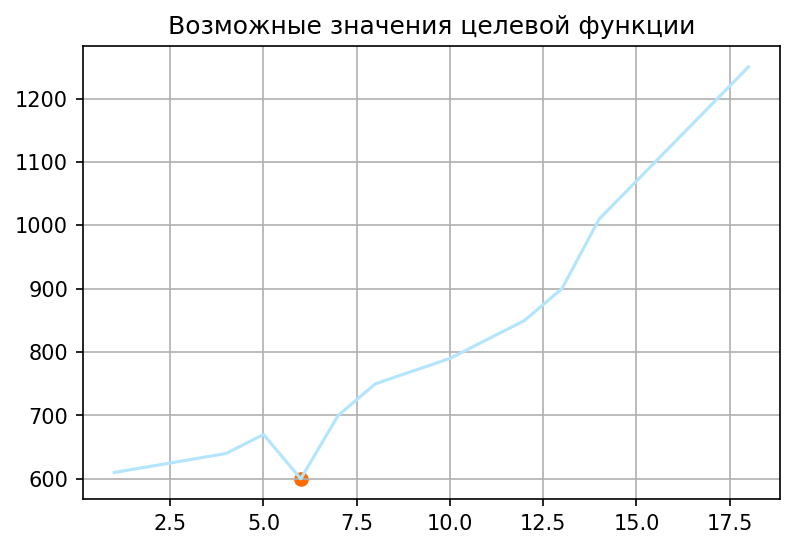

In [17]:
x = [item for item in a.plans_list if item[0] == 6]
x_point = 0
for i, plan in enumerate(x):
    if plan[3] == a.optimal_plan[0][3]:
        x_point = i+1
        break
x = [plan[3] for plan in x]

plt.subplots(dpi=150)
plt.scatter(x_point, a.optimal_plan[0][3], c='#FF6D00')
plt.plot(range(1, len(x)+1), x, c='#B3E5FC')
plt.title('Возможные значения целевой функции')
plt.grid(True)
plt.show()

In [18]:
a = Problem(**base_setup)
a.solve()
a._form_result()
optimal = [(x[0], x[1], x[2]) for x in a.optimal_plan]
costs = []
search_range = range(4, 20+1)
for PoSt in search_range:
    # print('===========================')
    tmp_setup = base_setup.copy()
    tmp_setup['price_of_storage'] = PoSt
    a = Problem(**tmp_setup)
    # a.debug = True
    a.solve()
    a._form_result()
    tmp = [(x[0], x[1], x[2]) for x in a.optimal_plan]
    costs.append(a.optimal_plan[0][-1])
    if tmp != optimal:
        print(
            'Минимальная стоимость хранения станка, при котором изменится оптимальный план:', 
            PoSt
        )
        break

# plt.plot(search_range, costs)
# plt.show()


Минимальная стоимость хранения станка, при котором изменится оптимальный план: 13


In [19]:

a = Problem(**base_setup)
# a.debug = True
a.solve()
a._form_result()
optimal = [(x[0], x[1], x[2]) for x in a.optimal_plan]
valid = []
costs = []
search_range = range(10, 500+1)
for PoSh_base in search_range:
    # print('===========================')
    tmp_setup = base_setup.copy()
    tmp_setup['base_price_of_shipping'] = PoSh_base
    a = Problem(**tmp_setup)
    a.solve()
    a._form_result()
    tmp = [(x[0], x[1], x[2]) for x in a.optimal_plan]
    costs.append(a.optimal_plan[0][-1])
    if tmp != optimal:
        pass
        # print(
        #     'Минимальная стоимость хранения станка, при котором изменится оптимальный план:', 
        #     PoSh_base
        # )
        # break
    else:
        valid.append(PoSh_base)

PoSh_base_min = min(valid)
PoSh_base_max = max(valid)
print(
    'Границы изменения постоянных затрат ' \
    'на совершение рейса, в которых найденный план ' \
    'является оптимальным:',
    f'[{PoSh_base_min}, {PoSh_base_max}]'
)


Границы изменения постоянных затрат на совершение рейса, в которых найденный план является оптимальным: [41, 500]


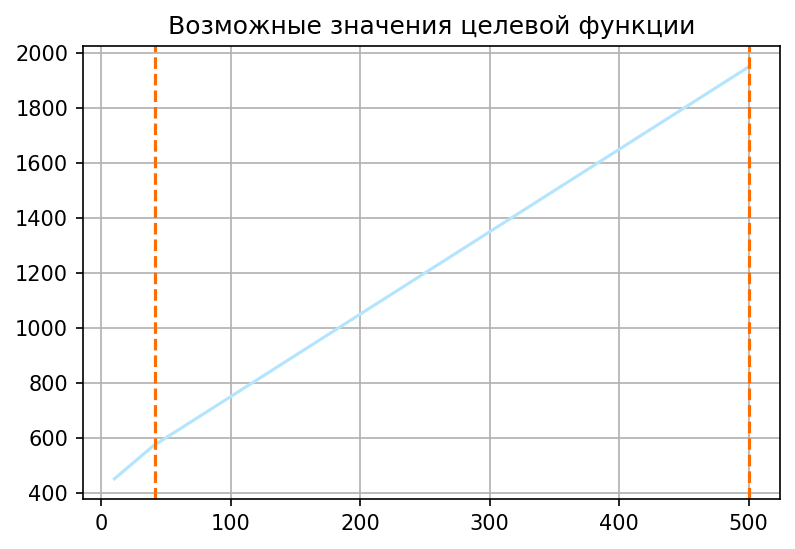

In [160]:
plt.subplots(dpi=150)
plt.grid(True)
plt.plot(search_range, costs, c='#B3E5FC')
plt.axvline(PoSh_base_min, ls='--', c='#FF6D00')
plt.axvline(PoSh_base_max, ls='--', c='#FF6D00')
plt.title('Возможные значения целевой функции')
plt.show()

In [20]:
new_setup = base_setup.copy()
new_setup['machines_at_end'] = 2
a = Problem(**new_setup)
print('solved:', a.solve())
a._form_result()

print('Оптимальный план:')
TableIt.printTable(a.optimal_plan)


solved: True
Оптимальный план:
+-----------------------+
| 6   | 0   | 2   | 630 |
| 5   | 0   | 0   | 520 |
| 4   | 0   | 0   | 520 |
| 3   | 1   | 0   | 410 |
| 2   | 4   | 1   | 240 |
| 1   | 4   | 4   | 40  |
+-----------------------+
